In [1]:
import pennylane as qml

In [2]:
# dictionary of wire numbers we want each letter of the alphabet to have
qubit = {'a':1, 'b':2, 'c':3, 'd':4, 'e':5, 'f':6, 'g':7, 'h':8, 'i':9, 'j':10,
         'k':11, 'l':12, 'm':13, 'n':14, 'o':15, 'p':16, 'q':17, 'r':18, 's':19,
         't':20, 'u':21, 'v':22, 'w':23, 'x':24, 'y':25, 'z':26}

In [3]:
def Solve(exp, vars, ops):
    # TODO: Initialize the qubits in superposition

    # lists to handle the helper qubits, the current qubit(s), 
    # and the operations on the recent two current qubits
    helpQ = list(range(vars+1, vars + ops)) + [0] 
    # we append 0 at the end, as we want our final output to be in wire 0
    currQ = []
    currOp = []

    #for char in exp:
        # TODO: Implement the logic for handling parentheses, AND, and OR
        # i.e. 
        # if the char is not ')'
        #            if the char is '(', '&', or '|', append it to currOp
        #            else, append the wire number of it to currQ
        # else, 
        #      while the most recent (last in the list) element of currOp doesn't become '('
        #            pop the two most recent current qubits in currQ, and the first
        #            element from helpQ (the output qubit for AND and OR), and the 
        #            current operation (i.e. '&' or '|')
        #            ... and apply the quantum equivalent of AND/OR accordingly
        #            followed by appending the output wire of AND/OR back to currQ
        #      pop this opening bracket '(' that we just closed, from currOp

    # returning the final outputs and the intial states that give those outputs
    # wires 0, 1, 2, 3, ... hold final_output, a, b, c, ... respectively
    return qml.counts(wires=list(range(vars+1))) # https://docs.pennylane.ai/en/stable/code/api/pennylane.counts.html

In [15]:
# Define the Solve function
def Solve(exp, vars, ops):
    # Initialize the qubits in superposition (Hadamard on all variable qubits)
    for i in range(1, vars + 1):
        qml.Hadamard(wires=i)
    
    # Lists to track helper qubits, current qubits, and operations
    helpQ = list(range(vars + 1, vars + ops)) + [0]  # The output is stored in wire 0
    currQ = []
    currOp = []

    for char in exp:
        if char not in ")":
            if char in "(&|":
                currOp.append(char)
            elif char.isalpha():
                currQ.append(qubit[char])  # Add variable's qubit wire number
        else:
            # Process until the matching '(' is found
            while currOp and currOp[-1] != "(":
                op = currOp.pop()
                b = currQ.pop()
                a = currQ.pop()
                out = helpQ.pop(0)

                if op == "&":
                    # Apply Toffoli for AND: output in 'out' qubit
                    qml.Toffoli(wires=[a, b, out])
                elif op == "|":
                    qml.PauliX(wires=a)
                    qml.PauliX(wires=b)
                    qml.Toffoli(wires=[a, b, out])
                    qml.PauliX(wires=a)
                    qml.PauliX(wires=b)
                    qml.PauliX(wires=out)  # <-- This extra inversion turns NOR into OR

                currQ.append(out)
            currOp.pop()  # Remove the matching '('

    # Return the count of results for wire 0 being 1
    return qml.counts(wires=list(range(vars + 1)))

In [16]:
## The number of solutions to the expression to equal 1

exp = ["(a|b)", "(a&b)", "((a&b)|c)", "((a|b)&((c&d)|e))", "((((a|b)&c)|a)&((d&e&f)|(g|h|i)))"]
vars = [2, 2, 3, 5, 9]
ops = [1, 1, 2, 4, 9]

n_sols = [0] * 5

for i in range(len(exp)):
    dev = qml.device(name = "default.qubit", wires = vars[i] + ops[i], shots = 10000)
    SOLVE = qml.QNode(Solve, dev)
    state = SOLVE(exp[i], vars[i], ops[i])
    for s in state.keys():
        if s[0]=='1':       # The final output of our calculation is in wire 0
            n_sols[i] += 1

for i in range(len(exp)):
    print(exp[i], "has", n_sols[i], "solutions.")

(a|b) has 3 solutions.
(a&b) has 1 solutions.
((a&b)|c) has 5 solutions.
((a|b)&((c&d)|e)) has 15 solutions.
((((a|b)&c)|a)&((d&e&f)|(g|h|i))) has 285 solutions.


In [9]:
# TODO: Print the 15 solutions returned for expression (4) to equal 1
@qml.qnode(dev)
def circuit():
    return Solve("((a|b)&((c&d)|e))", 5, 4)

# Run the circuit and get the counts.
counts = circuit()

# The measurement is performed on wires [0,1,2,3,4,5]:
# - The first bit (index 0) is the output qubit.
# - The remaining bits (indices 1–5) represent the variable assignments for a, b, c, d, e.
# We will extract and print only those assignments where the output is '1'.

satisfying_assignments = set()

for outcome, cnt in counts.items():
    # outcome is a bitstring of length 6; the first character corresponds to wire 0.
    if outcome[0] == '1':
        # Bits 1–5 represent the assignment for a, b, c, d, e.
        satisfying_assignments.add(outcome[1:])

print("Satisfying assignments for ((a|b)&((c&d)|e)) = 1:")
for sol in sorted(satisfying_assignments):
    print(sol)
    
print("Total number of satisfying assignments:", len(satisfying_assignments))

Satisfying assignments for ((a|b)&((c&d)|e)) = 1:
01001
01011
01101
01110
01111
10001
10011
10101
10110
10111
11001
11011
11101
11110
11111
Total number of satisfying assignments: 15


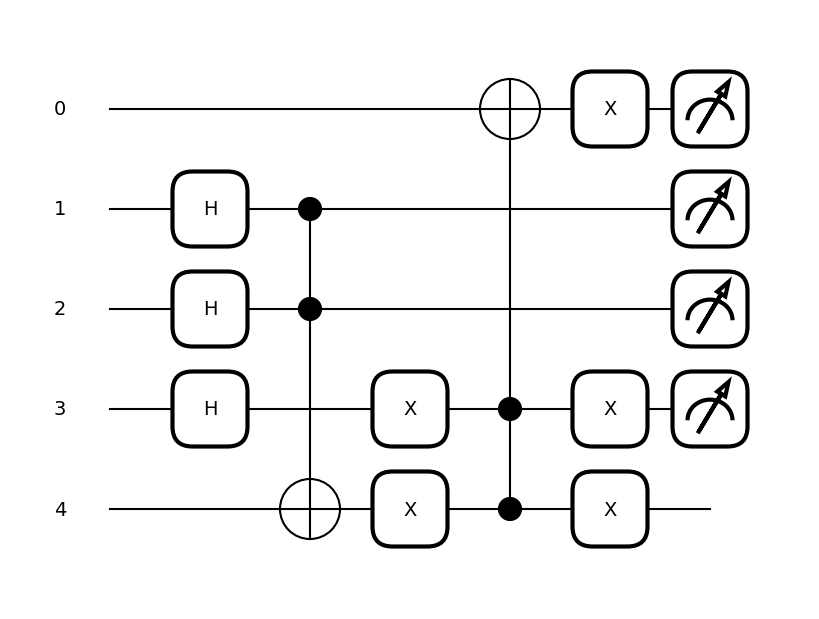

In [12]:
# TODO: Draw the circuit for expression (3)
import matplotlib.pyplot as plt
# Expression (3): "((a&b)|c)"
# We have 3 variable qubits (wires 1,2,3), one helper for AND (wire 4), and wire 0 as the output.
dev3 = qml.device("default.qubit", wires=5)

@qml.qnode(dev3)
def circuit3():
    return Solve("((a&b)|c)", 3, 2)

# Draw the circuit for expression (3)
#drawn_circuit = qml.draw(circuit3)
#print(drawn_circuit())

qml.draw_mpl(circuit3)()
plt.show()